In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import ipywidgets as widgets
from IPython.display import display
from enhancement_analysis import *
from fit_functions import *
from low_level import readCSVrows,writeCSVrows,calcEnhancement,readCSVcolumns
%matplotlib inline


In [4]:
results=readCSVcolumns('Processed_20190503/metadata_enhancement_stoichiometric_vs_power.csv',skip_header=1)
header = results[1]
print(header)
[iv,starts,stops]= results[0]

Done! Array read from Processed_20190503/metadata_enhancement_stoichiometric_vs_power.csv
[['Power (mW)', 'Start', 'Stop']]


A Jupyter Widget

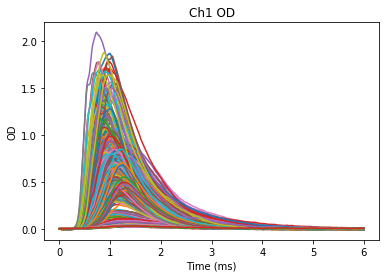

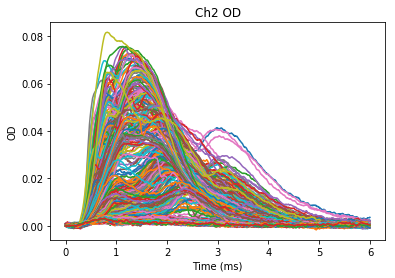

In [64]:
folder = '20190503'
skips = []
ABAB = True

start_arr = starts.astype(int)
stop_arr = stops.astype(int)
iv_arr = iv

enhancement = []

b_ODs = []
ub_ODs = []
b_int = []
ub_int = []

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
display(progress)

for _start,_stop,i in zip(start_arr,stop_arr,range(0,len(start_arr)*3,3)):
    
    ODs_1 = calculateSeriesOD(folder,_start,_stop,skips,ABAB=ABAB)
    int_1 = processData(ODs_1,[0,6])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    ODs_2 = calculateSeriesOD(folder,_start+1,_stop,skips,ABAB=ABAB)
    int_2 = processData(ODs_2,[0,6])
    progress.value = float(i/(len(start_arr)*3))
    i+=1
    b,ub,firstBlocked = identifyBUB(int_1,int_2,ch=1,equal=True,returnBool=True)
    b_int.append(b)
    ub_int.append(ub)
    if firstBlocked:
        b_ODs.append(ODs_1)
        ub_ODs.append(ODs_2)
    else:
        b_ODs.append(ODs_2)
        ub_ODs.append(ODs_1)
    progress.value = float(i/(len(start_arr)*3))
    i+=1
progress.value=1

#ODs = [Ch1 ODs, Ch 2 ODs, params]
#int = [Ch1 Integrated, Ch2 Integrated, Timestamp]

[[0, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6, 10], [9, 0], [13, 4], [13, 5], [14, 0], [19, 0], [25, 0], [27, 0], [28, 0], [29, 0]]


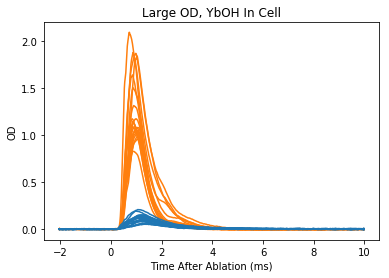

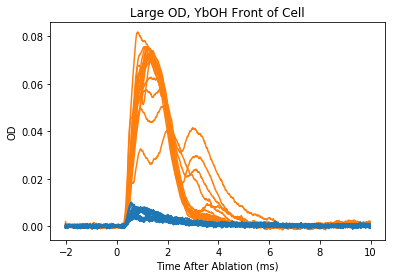

In [101]:
from low_level import timeArray

ub_big = []
idx = []
time_ms = []
plt.figure(1)
plt.title('Large OD, YbOH In Cell')
plt.xlabel('Time After Ablation (ms)')
plt.ylabel('OD')
plt.figure(2)
plt.title('Large OD, YbOH Front of Cell')
plt.xlabel('Time After Ablation (ms)')
plt.ylabel('OD')

for i in range(len(ub_ODs)):
    _ub_ch1 = ub_ODs[i][0]
    _ub_ch2 = ub_ODs[i][1]
    _p = ub_ODs[i][2]
    for j in range(len(_ub_ch1)):
        _trace_ch1 = _ub_ch1[j]
        _trace_ch2 = _ub_ch2[j]
        _time = timeArray(_p[j])
        if _trace_ch1.max()>1.8 or _trace_ch2.max()>0.07:
            ub_big.append([_trace_ch1,_trace_ch2])
            time_ms.append(_time)
            idx.append([i,j])
            plt.figure(1)
            plt.plot(_time,_trace_ch1,color='C1')
            plt.figure(2)
            plt.plot(_time,_trace_ch2,color='C1')
b_big = []
for _idx,k in zip(idx,range(len(idx))):
    [i,j] = _idx
    b_big.append([b_ODs[i][0][j],b_ODs[i][1][j]])
    plt.figure(1)
    plt.plot(time_ms[k],b_ODs[i][0][j],color='C0')
    plt.figure(2)
    plt.plot(time_ms[k],b_ODs[i][1][j],color='C0')
    
ub_big = np.array(ub_big)
b_big = np.array(b_big)
time_ms = np.array(time_ms)
print(idx)    

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


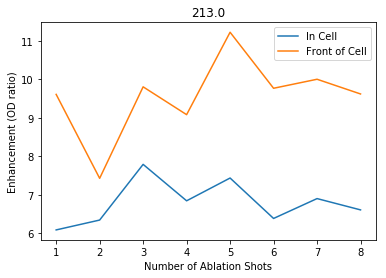

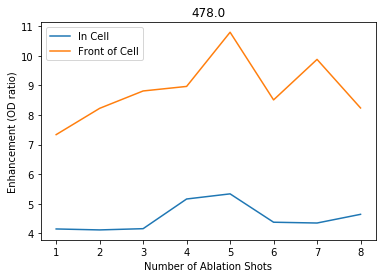

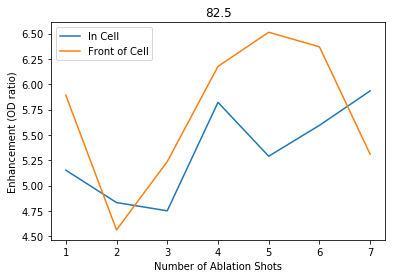

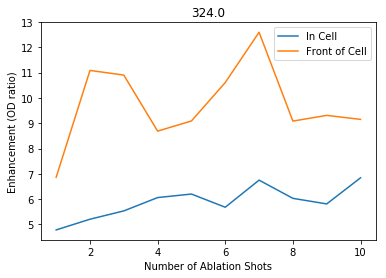

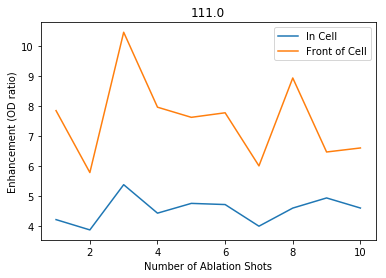

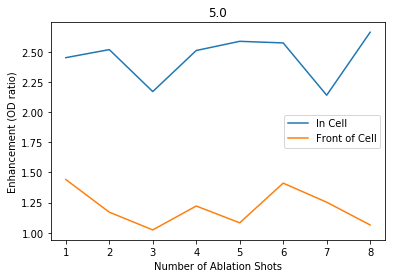

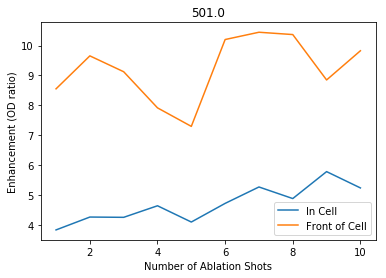

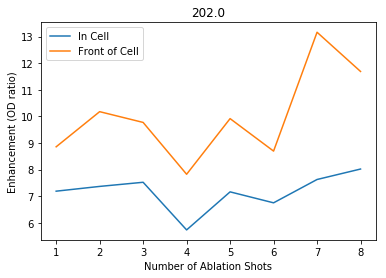

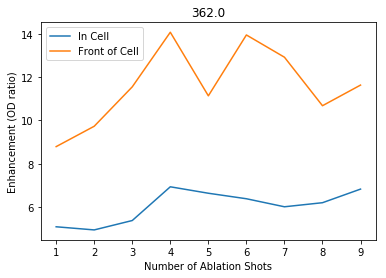

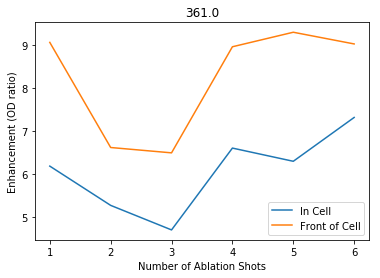

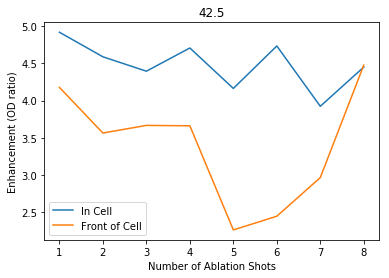

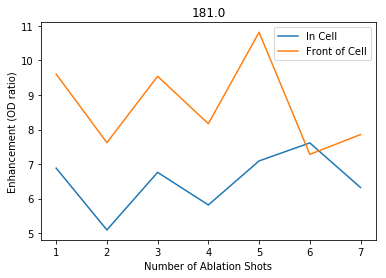

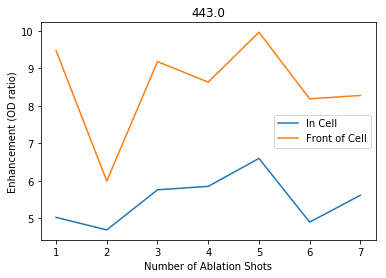

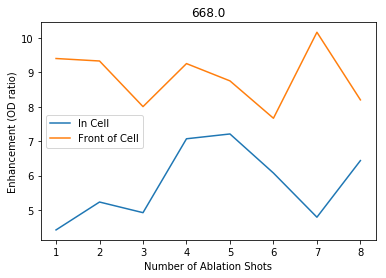

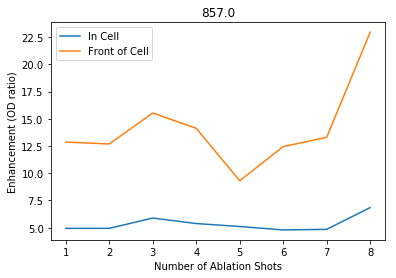

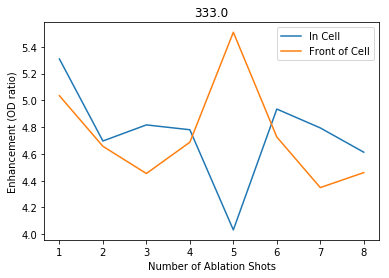

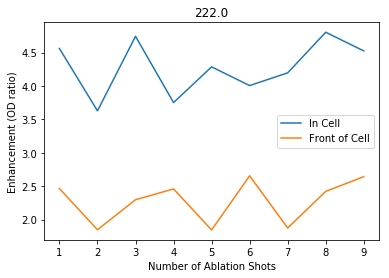

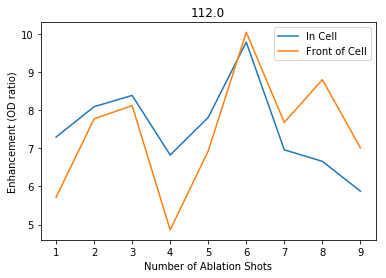

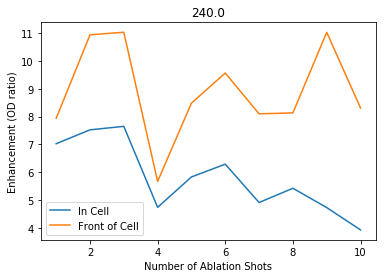

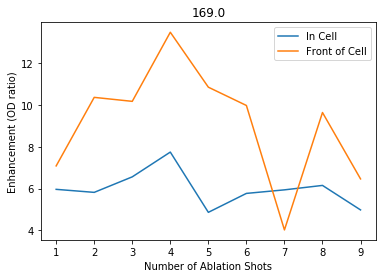

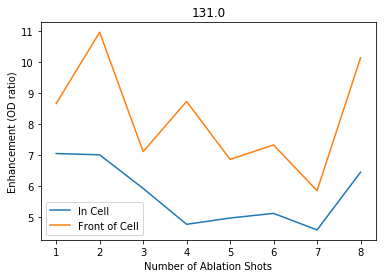

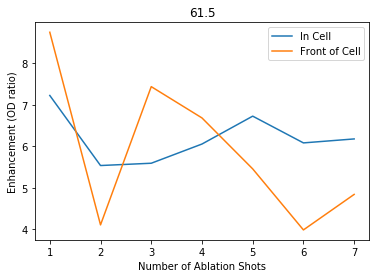

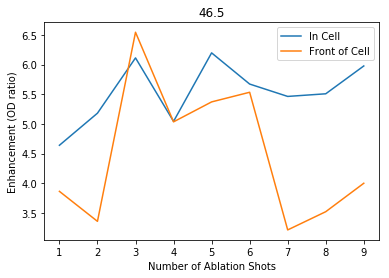

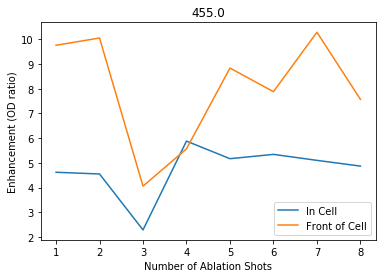

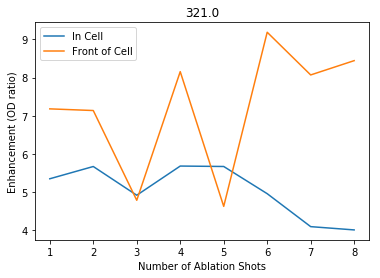

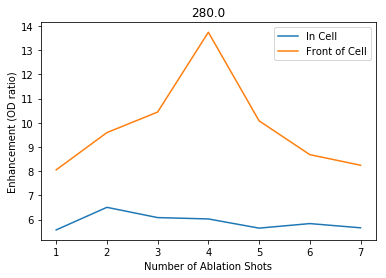

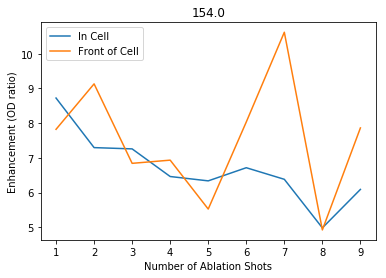

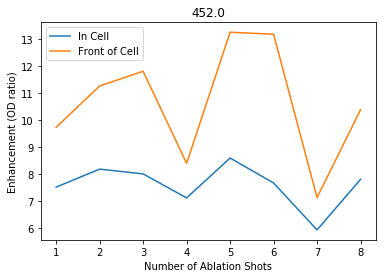

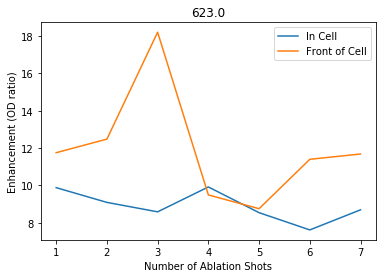

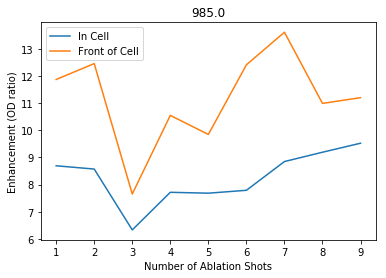

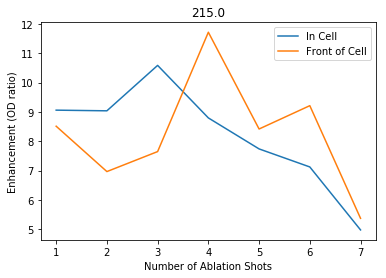

In [65]:
en_ch1 = []
en_ch2 = []
for _b,_ub in zip(b_int,ub_int):
    _en1 = calcEnhancement(_b[0],_ub[0])
    en_ch1.append(_en1[1:])
    _en2 = calcEnhancement(_b[1],_ub[1])
    en_ch2.append(_en2[1:])

cell = []
err_cell = []
front = []
err_front = []
for _en1,_en2,_iv in zip(en_ch1,en_ch2,iv):
    plt.figure()
    x = np.arange(1,len(_en1)+1)
    plt.title('{}'.format(_iv))
    plt.ylabel('Enhancement (OD ratio)')
    plt.xlabel('Number of Ablation Shots')
    plt.plot(x,_en1,label='In Cell')
    plt.plot(x,_en2,label='Front of Cell')
    plt.legend(loc='best')
    cell.append(np.array(_en1).mean())
    err_cell.append(np.array(_en1).std())
    front.append(np.array(_en2).mean())
    err_front.append(np.array(_en2).std())

In [70]:
en_cell_sort = np.array(sortData(iv,cell))
err_cell_sort = np.array(sortData(iv,err_cell))
en_front_sort = np.array(sortData(iv,front))
err_front_sort = np.array(sortData(iv,err_front))
iv_sort = np.array(sorted(iv))

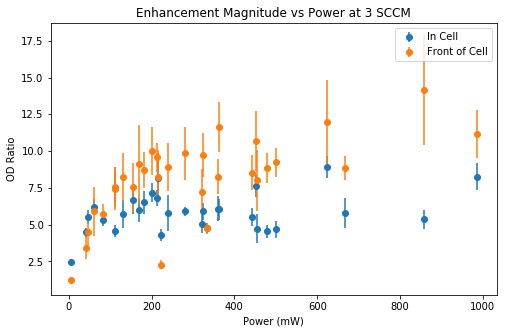

In [67]:
plt.figure(figsize=(8,5))
plt.title('Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(iv_sort,en_cell_sort,yerr=err_cell_sort,marker='o',linestyle='None',label='In Cell')
plt.errorbar(iv_sort,en_front_sort,yerr=err_front_sort,marker='o',linestyle='None',label='Front of Cell')
plt.legend(loc='best')

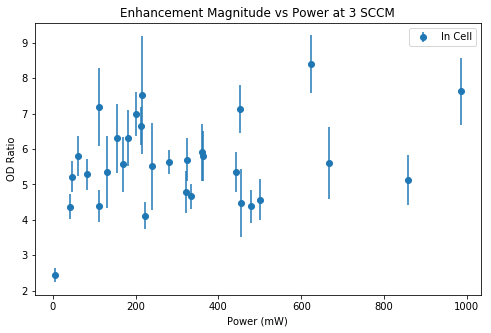

In [18]:
plt.figure(figsize=(8,5))
plt.title('Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(iv_sort,en_cell_sort,yerr=err_cell_sort,marker='o',linestyle='None',label='In Cell')
plt.legend(loc='best')

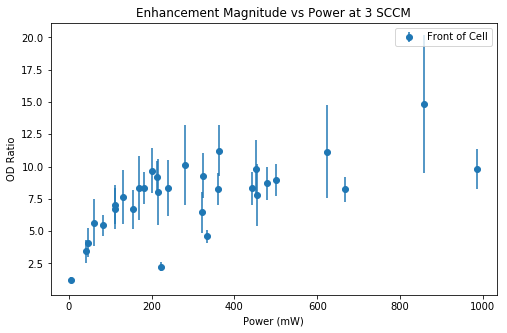

In [19]:
plt.figure(figsize=(8,5))
plt.title('Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(iv_sort,en_front_sort,yerr=err_front_sort,marker='o',linestyle='None',label='Front of Cell')
plt.legend(loc='best')

In [20]:
iv_sort

array([  5. ,  42.5,  46.5,  61.5,  82.5, 111. , 112. , 131. , 154. ,
       169. , 181. , 202. , 213. , 215. , 222. , 240. , 280. , 321. ,
       324. , 333. , 361. , 362. , 443. , 452. , 455. , 478. , 501. ,
       623. , 668. , 857. , 985. ])

In [45]:
np.argwhere(iv_sort==333)

array([[19]], dtype=int64)

In [71]:
_iv = np.delete(iv_sort,[14,19])
_en_cell = np.delete(en_cell_sort,[14,19])
_en_front = np.delete(en_front_sort,[14,19])
_err_cell = np.delete(err_cell_sort,[14,19])
_err_front = np.delete(err_front_sort,[14,19])

<ErrorbarContainer object of 3 artists>

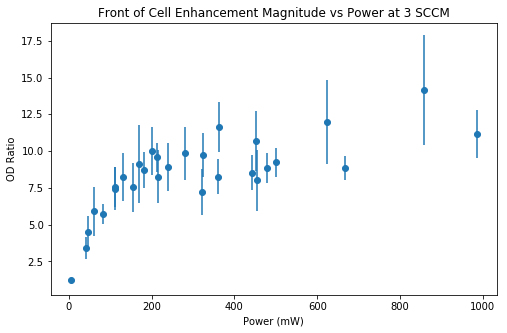

In [76]:
plt.figure(figsize=(8,5))
plt.title('Front of Cell Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(_iv,_en_front,yerr=_err_front,marker='o',linestyle='None',label='Front of Cell')
#plt.legend(loc='best')

<ErrorbarContainer object of 3 artists>

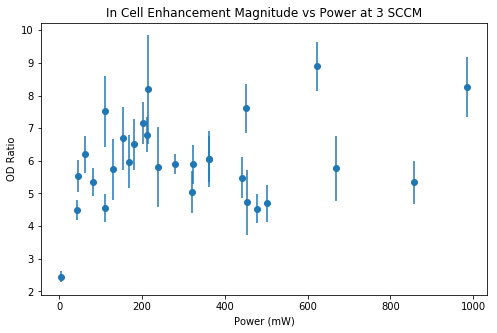

In [79]:
plt.figure(figsize=(8,5))
plt.title('In Cell Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(_iv,_en_cell,yerr=_err_cell,marker='o',linestyle='None',label='In Cell')
#plt.legend(loc='best')

In [96]:
def dopplerPowerExcitedFraction(I,N,T):
    Isat = 0.04626 #mW/cm^2
    gamma = 0.1823 #MHz
    doppler = 33.58*np.sqrt(T) #MHz/sqrt(Kelvin)
    s = I/Isat
    N_excited = N * s/np.sqrt(1+s) * gamma/doppler
    return 1+N_excited
def powerIntensity(ptot,d=0.2):
    #assuming gaussian beam
    #diameter d is in cm, ptot is in mW
    I = 2*ptot/(np.pi * (d/2)**2)
    return I #mW/cm^2
def fitDopplerPower(xscale,data,guess=[1,4],sigma=None,bounds=None,plot=True):
    bounds=([0,4],[np.inf,np.inf])
    function = dopplerPowerExcitedFraction
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]

def voigtLineshape(x,lor_fwhm,gauss_stdev):
    max_value = voigt(x,lor_fwhm/2,gauss_stdev,0,1,0)
    return max_value
def voigtExcitedFraction(I,N):
    Isat = 0.04626 #mW/cm^2
    s = I/Isat
    lor_fwhm = 0.1823*np.sqrt(1+s) #MHz
    T=4
    gauss_stdev = 11.87 *np.sqrt(T) #MHz/sqrt(Kelvin)
    N_excited = np.zeros(len(I))
    for _lor,i in zip(lor_fwhm,range(len(I))):
        x,dx = np.linspace(-_lor/2,_lor/2,num=100,retstep=True)
        N_excited[i] = N * voigtLineshape(x,_lor,gauss_stdev).sum()*dx
    return N_excited
def voigtExcitedFraction2(I,N):
    Isat = 0.04626 #mW/cm^2
    s = I/Isat
    lor_fwhm = 0.1823*np.sqrt(1+s) #MHz
    T=4
    gauss_stdev = 11.87 *np.sqrt(T) #MHz/sqrt(Kelvin)
    N_excited = N * voigtLineshape(0,lor_fwhm,gauss_stdev)*lor_fwhm
    return 1+N_excited
def fitVoigtDopplerPower(xscale,data,guess=1,sigma=None,bounds=None,plot=True):
    function = 1+voigtExcitedFraction
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]
def fitCrossSection(xscale,data,guess=[10,1],sigma=None,bounds=None,plot=True):
    function = excitedFraction
    bounds = ([0,0],[np.inf,np.inf])
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]
def _voigt(x,lor,sig,mean=0,n=1,c=0): #lor = hwhm, sigma = gaussian stdev
    z= ((x-mean) + 1j*lor)/(sig*np.sqrt(2))
    value = n*np.real(wofz(z))/(sig*np.sqrt(2*np.pi))+c
    return value
def excitedFraction(I,N,a):
    Isat = 0.13878 #mW/cm^2
    s = I/Isat*a
    gamma = 1.145 #MHz*2pi
    lor_hwhm = gamma*np.sqrt(1+s)/2
    gauss_sig = 149.17/np.sqrt(4)*np.sqrt(12) #MHz*2pi
    rhoee = np.pi*(s/4)/np.sqrt(1+s)*gamma * _voigt(0,lor_hwhm,gauss_sig)
    return 1+N*rhoee
def voigtWidth(I,N,a,T):
    Isat = 0.13878 #mW/cm^2
    s = I/Isat*a
    gamma = 1.145 #MHz*2pi
    lor_hwhm = gamma*np.sqrt(1+s)/2
    gauss_sig = 149.17/np.sqrt(4)*np.sqrt(T) #MHz*2pi
    lorMHz = lor_hwhm/(2*np.pi)
    gaussMHz = gauss_sig/(2*np.pi)
    freqMHz = np.linspace(-500,500,num=10000)
    fwhm = []
    for lor in lorMHz:
        fwhm.append(findFWHM(freqMHz, _voigt(freqMHz,lor,gaussMHz)))
    fwhm = np.array(fwhm)
    stdev = fwhm/(2*np.sqrt(2*np.log(2)))
    return N*stdev
def fitVoigtWidth(xscale,data,guess=[4,1,4],sigma=None,bounds=None,plot=True):
    function = voigtWidth
    bounds = ([0,0,0],[np.inf,np.inf,30])
    params,error,residuals = fitFunction(xscale,data,function,guess,sigma,plot,bounds)
    return [params,error,residuals]

def findNearestIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def lorentzian(x,lor): #lor = hwhm
    f = 1/np.pi * lor/(x**2 + lor**2)
    return f

def gaussian(x,sig):
    f = 1/np.sqrt(2*np.pi*sig**2)*np.exp(-x**2/(2*sig**2))
    return f

def findFWHM(x,data):
    half_max = data.max()/2
    idx_max = np.argmax(data)
    data_L = data[0:idx_max]
    x_L = x[0:idx_max]
    data_R = data[idx_max:]
    x_R = x[idx_max:]
    half_L = x_L[findNearestIdx(data_L,half_max)]
    half_R = x_R[findNearestIdx(data_R,half_max)]
    FWHM = abs(half_R-half_L)
    return FWHM
    

[Norm, Sat] =  [11.112539  5.60792 ] Error = [0.847175 2.709184]


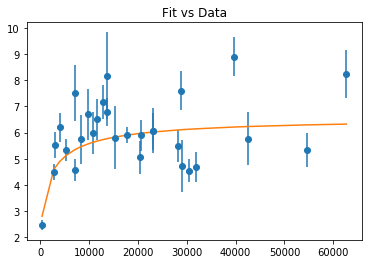

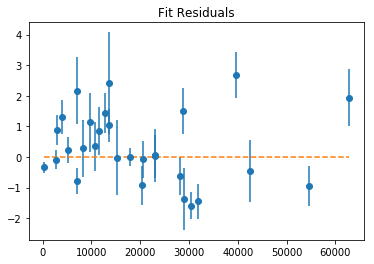

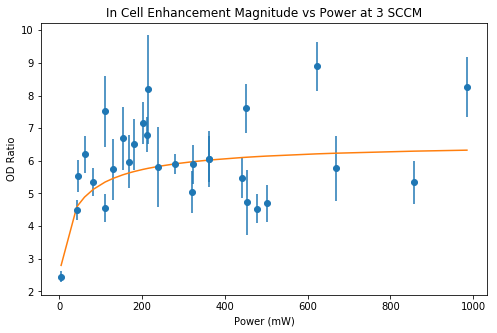

In [91]:
intensity_all = powerIntensity(_iv)
params,error,residuals=fitCrossSection(intensity_all,_en_cell,sigma=_err_cell)
print('[Norm, Sat] = ',params,'Error =',error)
plt.figure(figsize=(8,5))
plt.title('In Cell Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(_iv,_en_cell,yerr=_err_cell,marker='o',linestyle='None',label='In Cell')
plt.plot(_iv,excitedFraction(intensity_all,*params))

[Norm, Sat] =  [27.73245  0.95268] Error = [4.499041 0.580606]


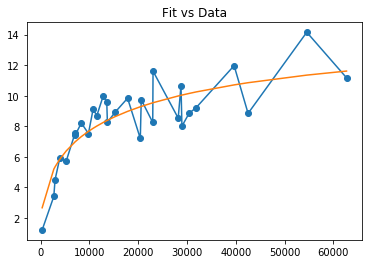

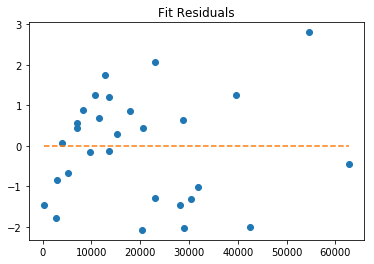

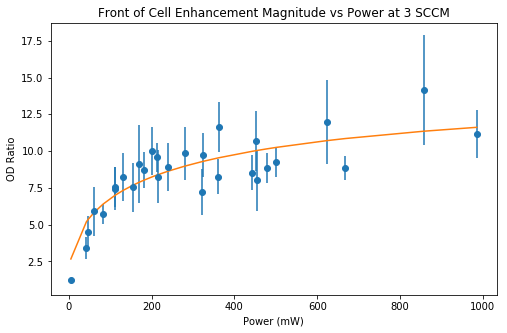

In [99]:
intensity_all = powerIntensity(_iv)
params,error,residuals=fitCrossSection(intensity_all,_en_front)
print('[Norm, Sat] = ',params,'Error =',error)
plt.figure(figsize=(8,5))
plt.title('Front of Cell Enhancement Magnitude vs Power at 3 SCCM')
plt.xlabel('Power (mW)')
plt.ylabel('OD Ratio')
plt.errorbar(_iv,_en_front,yerr=_err_front,marker='o',linestyle='None',label='Front of Cell')
plt.plot(_iv,excitedFraction(intensity_all,*params))